# Segmentación de imágenes basada en agrupamiento aglutinante

### Incluir bibliotecas

In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from skimage       import data
from skimage.color import rgb2grey

from scipy.stats     import entropy
from scipy.stats     import mannwhitneyu as utest
from multiprocessing import Pool

### Métrica basada en diferencia de desvianción estándar

In [2]:
def metric_m(X,Y,e):
    x = np.abs( X.mean() - Y.mean() )
    return x<e

def metric_std(X,Y,e):
    x = np.abs( X.std() - Y.std() )
    return x<e

def aggl(X,X0,C,C0,e=.5):
    m = metric_m( X,X0, e)
    c = np.min( [C,C0] )
    return c, m

### Ejemplo de una matriz aleatoria $6\times 5$

In [3]:
M, N = 6,5
D    = np.random.randn( M*N ).reshape( M,N )
C    = np.arange( D.size )   .reshape( M,N )
np.random.shuffle(C)
C

array([[ 5,  6,  7,  8,  9],
       [ 0,  1,  2,  3,  4],
       [25, 26, 27, 28, 29],
       [20, 21, 22, 23, 24],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

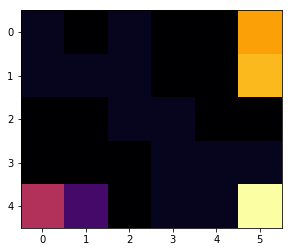

In [4]:
e = 2.
for i in range(M-1):
    for j in range(N-1):
        m,c = aggl( D[i,j  ], 
                    D[i,j+1],
                    C[i,j  ], 
                    C[i,j+1], e)
        if m:
            C[i,j  ] = c
            C[i,j+1] = c
        
        m,c = aggl( D[i  ,j], 
                    D[i+1,j],
                    C[i,j  ], 
                    C[i+1,j], e)
        if m:
            C[i  ,j] = c
            C[i+1,j] = c

plt.imshow(C.T,cmap='inferno')

In [5]:
C

array([[ 1,  1,  0,  0,  9],
       [ 0,  1,  0,  0,  4],
       [ 1,  1,  1,  0,  0],
       [ 0,  0,  1,  1,  1],
       [ 0,  0,  0,  1,  1],
       [15, 16,  0,  1, 19]])

### Ejemplo con una imagen

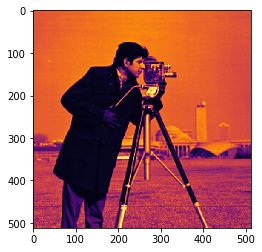

In [6]:
#im = rgb2grey( data.checkerboard() )
#im = rgb2grey( data.coins() )
im = rgb2grey( data.camera() )
#im = rgb2grey( data.chelsea() )
im = im/256.
plt.imshow(im,'inferno')

In [7]:
n     = 13
overl = .5
step  = int( overl*n )

x,y = im.shape
x   = np.arange( 0,x-step,step)
y   = np.arange( 0,y-step,step)

x,y = np.meshgrid(x,y)

CPU times: user 724 ms, sys: 54.4 ms, total: 779 ms
Wall time: 724 ms


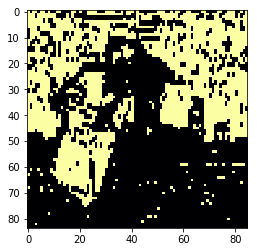

In [8]:
%%time
e = .01
N = x.shape[1]
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
for n,(i,j) in enumerate( zip( x.ravel(),y.ravel() ) ):
    m,c = aggl( im[i:i+step,j     :j  +step], 
                im[i:i+step,j+step:j+2*step],
                C[n/N, n   %N],
                C[n/N,(n+1)%N], e)
    if m:
        C[n/N, n   %N] = c
        C[n/N,(n+1)%N] = c

    m,c = aggl( im[i     :i+  step,j:j+step], 
                im[i+step:i+2*step,j:j+step],
                C[n/N, n   %N],
                C[n/N,(n+1)%N], e)
    if m:
        C[n/N, n   %N] = c
        C[n/N,(n+1)%N] = c
    
plt.imshow(C[:,:-1].T ,cmap='inferno')

In [34]:
n,N

(7224, 85)

In [9]:
C

array([[   1,    1,    1, ...,    0,    0,    0],
       [   0,    1,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       ..., 
       [   1,    0,    0, ...,    0,    0,    0],
       [   0,    0,    1, ...,    0,    0, 4629],
       [   1,    1,    1, ...,    0,    0,    0]])

### Histograma como métrica

In [10]:
def Hist(x, bins):
    h = np.histogram( x.ravel(),bins=bins )
    return h[1]

In [11]:
bins = 255

In [12]:
temp = []
for i in range(100)[1::2]:
    temp.append(i)
    
print temp

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [13]:
temp = [ np.sin(i) for i in range(100)[::2] ]

print(temp)

[0.0, 0.90929742682568171, -0.7568024953079282, -0.27941549819892586, 0.98935824662338179, -0.54402111088936977, -0.53657291800043494, 0.99060735569487035, -0.2879033166650653, -0.75098724677167605, 0.91294525072762767, -0.0088513092904038762, -0.90557836200662389, 0.76255845047960269, 0.27090578830786904, -0.98803162409286183, 0.55142668124169059, 0.52908268612002385, -0.99177885344311578, 0.29636857870938532, 0.74511316047934883, -0.91652154791563378, 0.017701925105413577, 0.90178834764880922, -0.76825466132366682, -0.26237485370392877, 0.98662759204048534, -0.55878904885161629, -0.52155100208691185, 0.99287264808453712, -0.30481062110221668, -0.73918069664922281, 0.92002603819679063, -0.026551154023966794, -0.8979276806892913, 0.77389068155788909, 0.25382336276203626, -0.98514626046824738, 0.56610763689818033, 0.51397845598753522, -0.99388865392337522, 0.31322878243308516, 0.73319032007329221, -0.92345844700405977, 0.03539830273366068, 0.89399666360055785, -0.77946606961580467, -0.2

In [14]:
%%time
H = []
for n,(i,j) in enumerate( zip( x.ravel(),y.ravel() ) ):
    h = Hist( im[i:i+step,j:j+step].ravel(),bins ) 
    H.append( h[1] )

CPU times: user 845 ms, sys: 0 ns, total: 845 ms
Wall time: 843 ms


In [15]:
%%time
H       = []
pool    = Pool(processes=8)
results = [ pool.apply_async(  Hist, args=(im[i:i+step,j:j+step].ravel(),bins,) ) 
                                for i,j in zip( x.ravel(),y.ravel() ) ]

H  = [p.get() for p in results]
H  = np.array(H)

CPU times: user 1.24 s, sys: 570 ms, total: 1.81 s
Wall time: 1.43 s


In [16]:
H.shape

(7225, 256)

In [17]:
s = x.shape
H = H.reshape( s[0],s[1],H.shape[-1] )

In [18]:
%%time
poolr = Pool(processes=16)
pooll = Pool(processes=16)
R, L   = [], []
for i in range(s[0]-1):
    for j in range(s[1]-1):
        R.append(
          poolr.apply_async(  utest, args=(H[i,j],H[i,j+1],) )
        )
        L.append(
          pooll.apply_async(  utest, args=(H[i,j],H[i+1,j],) )
        )
        

uwr  = [r.get() for r in R]
uwl  = [l.get() for l in L]
uwr  = np.array(uwr)
uwl  = np.array(uwl)

CPU times: user 2.15 s, sys: 864 ms, total: 3.01 s
Wall time: 2.68 s


In [19]:
uwr = uwr.reshape( s[0]-1,s[1]-1,2 )
uwl = uwl.reshape( s[0]-1,s[1]-1,2 )

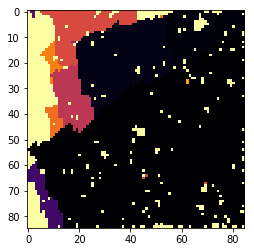

In [20]:
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = 0.005
for i in range( uwr.shape[0] ):
    for j in range( uwr.shape[1] ):
        if uwr[i,j,1] < e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        if uwl[i,j,1] < e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c

C[C>50] = 50
plt.imshow(C.T ,cmap='inferno')

In [21]:
set( C.ravel() )

{0, 1, 2, 10, 13, 20, 25, 27, 29, 31, 34, 35, 36, 40, 48, 50}

In [22]:
H.shape

(85, 85, 256)

In [23]:
def distance(X,Y):
    return sum( (X-Y)**2 )

In [25]:
poolr = Pool(processes=8)
pooll = Pool(processes=8)
R, L  = [], []
for i in range(H.shape[0]-1):
    for j in range(H.shape[1]-1):
        R.append( poolr.apply_async(  distance,args=(H[i,j],H[i  ,j+1],) ) )
        L.append( pooll.apply_async(  distance,args=(H[i,j],H[i+1,j  ],) ) )

enr = [r.get() for r in R]
enr = np.array(enr)
enl = [l.get() for l in L]
enl = np.array(enl)

In [26]:
s   = H.shape
enl = enl.reshape( s[0]-1,s[1]-1 )
enr = enr.reshape( s[0]-1,s[1]-1 )

CPU times: user 259 ms, sys: 28.9 ms, total: 288 ms
Wall time: 236 ms


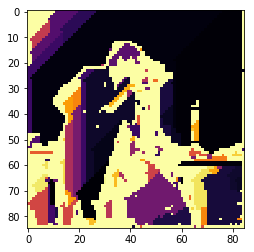

In [31]:
%%time
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = 1.
for i in range( enr.shape[0]-1 ):
    for j in range( enr.shape[1]-1 ):
        if enr[i,j] < e:
        #if abs( en[i,j]-en[i,j+1] )<e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        if enl[i,j] < e:
        #if abs( en[i+1,j]-en[i,j] )<e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c

#plt.imshow(C.T ,cmap='inferno')
C[C>220] = 220
plt.imshow(C.T ,cmap='inferno')

In [100]:
set(C.ravel())

{0,
 1,
 2,
 3,
 13,
 27,
 43,
 52,
 55,
 93,
 108,
 109,
 127,
 130,
 137,
 202,
 214,
 220,
 232,
 239,
 425,
 444,
 458,
 485,
 486,
 528,
 595,
 624,
 765,
 828,
 856,
 875,
 935,
 957,
 969,
 972,
 1057,
 1116,
 1117,
 1119,
 1157,
 1188,
 1224,
 1236,
 1240,
 1276,
 1299,
 1333,
 1367,
 1399,
 1441,
 1513,
 1603,
 1626,
 1642,
 1654,
 1702,
 1721,
 1742,
 1759,
 1775,
 1805,
 1822,
 1834,
 1884,
 2034,
 2041,
 2070,
 2155,
 2255,
 2300,
 2379,
 2420,
 2506,
 2540,
 2579,
 2600,
 2693,
 2705,
 2709,
 2762,
 2817,
 2819,
 2822,
 2872,
 2882,
 2901,
 2966,
 2979,
 3029,
 3032,
 3184,
 3248,
 3271,
 3277,
 3334,
 3481,
 3583,
 3619,
 3633,
 3653,
 3660,
 3674,
 3730,
 3751,
 3758,
 3766,
 3814,
 3914,
 3917,
 3970,
 3977,
 3996,
 4046,
 4157,
 4197,
 4199,
 4207,
 4216,
 4228,
 4237,
 4249,
 4278,
 4297,
 4334,
 4345,
 4406,
 4421,
 4524,
 4541,
 4568,
 4573,
 4614,
 4701,
 4962,
 4965,
 4977,
 5025,
 5051,
 5077,
 5084,
 5102,
 5223,
 5236,
 5285,
 5322,
 5353,
 5391,
 5465,
 5476,


In [123]:
s = H.shape
H = H.reshape( s[0]*s[1],s[2] )

In [124]:
%%time
pool = Pool(processes=8)
R    = [ pool.apply_async(  entropy,args=(h,) ) for h in H ]

en = [r.get() for r in R]
en = np.array(en)

CPU times: user 1.31 s, sys: 2.53 s, total: 3.84 s
Wall time: 2.04 s


In [125]:
en = en.reshape(x.shape)

CPU times: user 328 ms, sys: 233 ms, total: 562 ms
Wall time: 365 ms


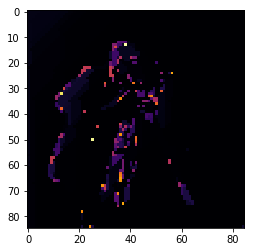

In [135]:
%%time
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = .06
for i in range( x.shape[0]-1 ):
    for j in range( x.shape[1]-1 ):
        #if enr[i,j] < e:
        if abs( en[i,j]-en[i,j+1] )<e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        #if enl[i,j] < e:
        if abs( en[i+1,j]-en[i,j] )<e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c

#plt.imshow(C.T ,cmap='inferno')
#C[C>300] = 300
plt.imshow(C.T ,cmap='inferno')

In [ ]:
set(C.ravel())

In [136]:
from sklearn.metrics.cluster import normalized_mutual_info_score as mis

In [ ]:
%%time
H       = []
pool    = Pool(processes=20)
results = [ pool.apply_async(  Hist, args=(im[i:i+step,j:j+step],bins,) ) 
                                for i,j in zip( x.ravel(),y.ravel() ) ]

H  = [p.get() for p in results]
H  = np.array(H)